### Set autoreload

In [1]:
%load_ext autoreload
%autoreload 2

init_mesh_viewer = False

### Import Dependency

In [2]:
import torch
import numpy as np
import time
import h5py 
import random

from os import path as osp
import os
import glob

import matplotlib.pyplot as plt

from body_visualizer.mesh.mesh_viewer import MeshViewer
from human_body_prior.tools.omni_tools import copy2cpu as c2c
from human_body_prior.body_model.body_model import BodyModel

from utils import plot_mesh, plot_xyz

os.environ['PYOPENGL_PLATFORM'] = 'egl' # for visualization in SSH

### Set directory path and other settings

In [3]:
h5py_dir = '/home/cotton_ahn/dataset/AMASS_h5py/'
smpl_dir = './body_models/smplx/'
bridge_str = '+++'
gender_list = ['neutral', 'female', 'male']

### Set device 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### import random data from the h5py_dir.

In [5]:
hdf5_list = glob.glob(osp.join(h5py_dir, '*.hdf5'))
chosen_fp = random.choice(hdf5_list)
dataset = h5py.File(chosen_fp, 'r')
print('Import {}'.format(chosen_fp))

Import /home/cotton_ahn/dataset/AMASS_h5py/BMLmovi.hdf5


In [6]:
dataset_keys = list(dataset.keys())
chosen_key = random.choice(dataset_keys)
chosen_motion = dataset[chosen_key]
print('Visualize "{}" action of subject "{}"'.format(chosen_key.split(bridge_str)[1], 
                                                            chosen_key.split(bridge_str)[0]))

Visualize "Subject_42_F_14" action of subject "Subject_42_F_MoSh"


In [7]:
betas = chosen_motion['betas']
num_betas = len(betas)
poses = chosen_motion['poses'] # T by 165
trans = chosen_motion['trans'] # T by 3
gender = gender_list[np.asarray(chosen_motion['gender'])]
num_frames = len(trans)

print('Gender : {}, this motion has {} frames'.format(gender, num_frames))

Gender : male, this motion has 175 frames


### Define body model

In [8]:
bm_smplx_fname = osp.join(smpl_dir, '{}/model.npz'.format(gender))

bm = BodyModel(bm_fname=bm_smplx_fname, num_betas=num_betas).to(device)

faces = c2c(bm.f)
num_verts = bm.init_v_template.shape[1]

In [9]:
body_params = {'root_orient': torch.Tensor(poses[:, :3]),
               'pose_body': torch.Tensor(poses[:, 3:66]),
               'pose_hand': torch.Tensor(poses[:, 75:75+90]),
               'pose_jaw': torch.Tensor(poses[:, 66:69]),
               'pose_eye' : torch.Tensor(poses[:, 69:75]),
               'trans': torch.Tensor(trans),
               'betas': torch.Tensor(np.repeat(betas[:num_betas][np.newaxis], repeats=num_frames, axis=0)),
               }

# I don't know why but adding "pose_hand" makes the whole motion a little bit weird. This setting is recommended.
body = bm(**{k:v.to(device) for k,v in body_params.items() if k in ['pose_body', 
                                                                    'root_orient',
                                                                    'trans'
                                                                    ]})


### Start Plot

In [10]:
# run this cell only once. Otherwise it makes error. 
if not init_mesh_viewer:
    imw, imh = 640, 480
    mv = MeshViewer(imw, imh)
    mv.set_cam_trans([0, 1, 4])
    init_mesh_viewer = True

### Plot mesh

<IPython.core.display.Javascript object>


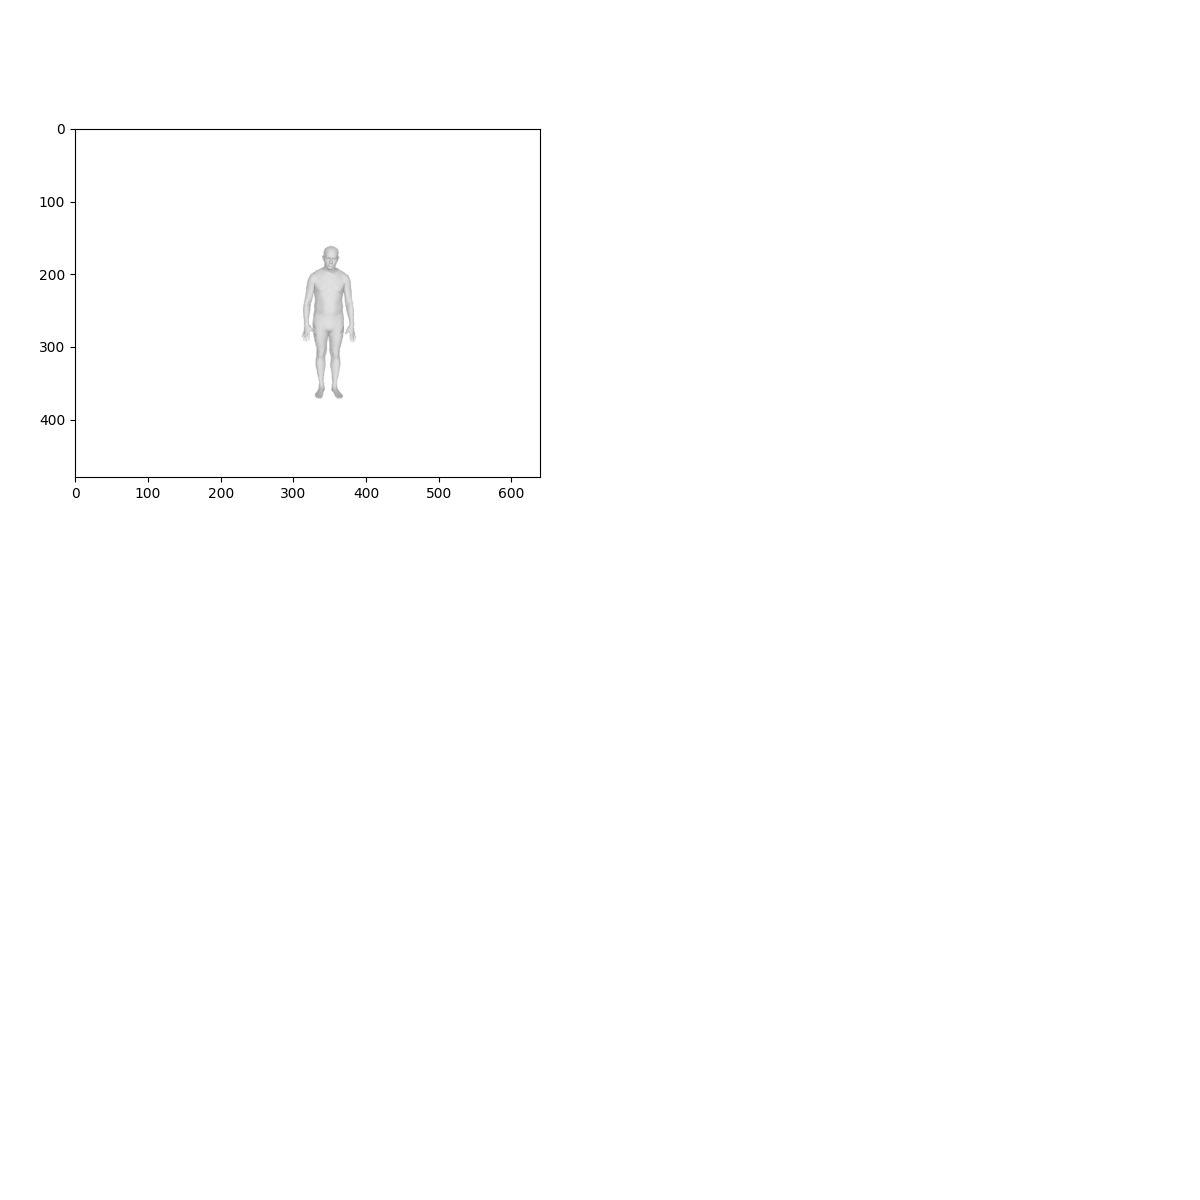

In [11]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_mesh(fig, ax, mv, body.v, faces, num_verts)

### Plot XYZ points. body.Jtr is a set of xyz points

<IPython.core.display.Javascript object>


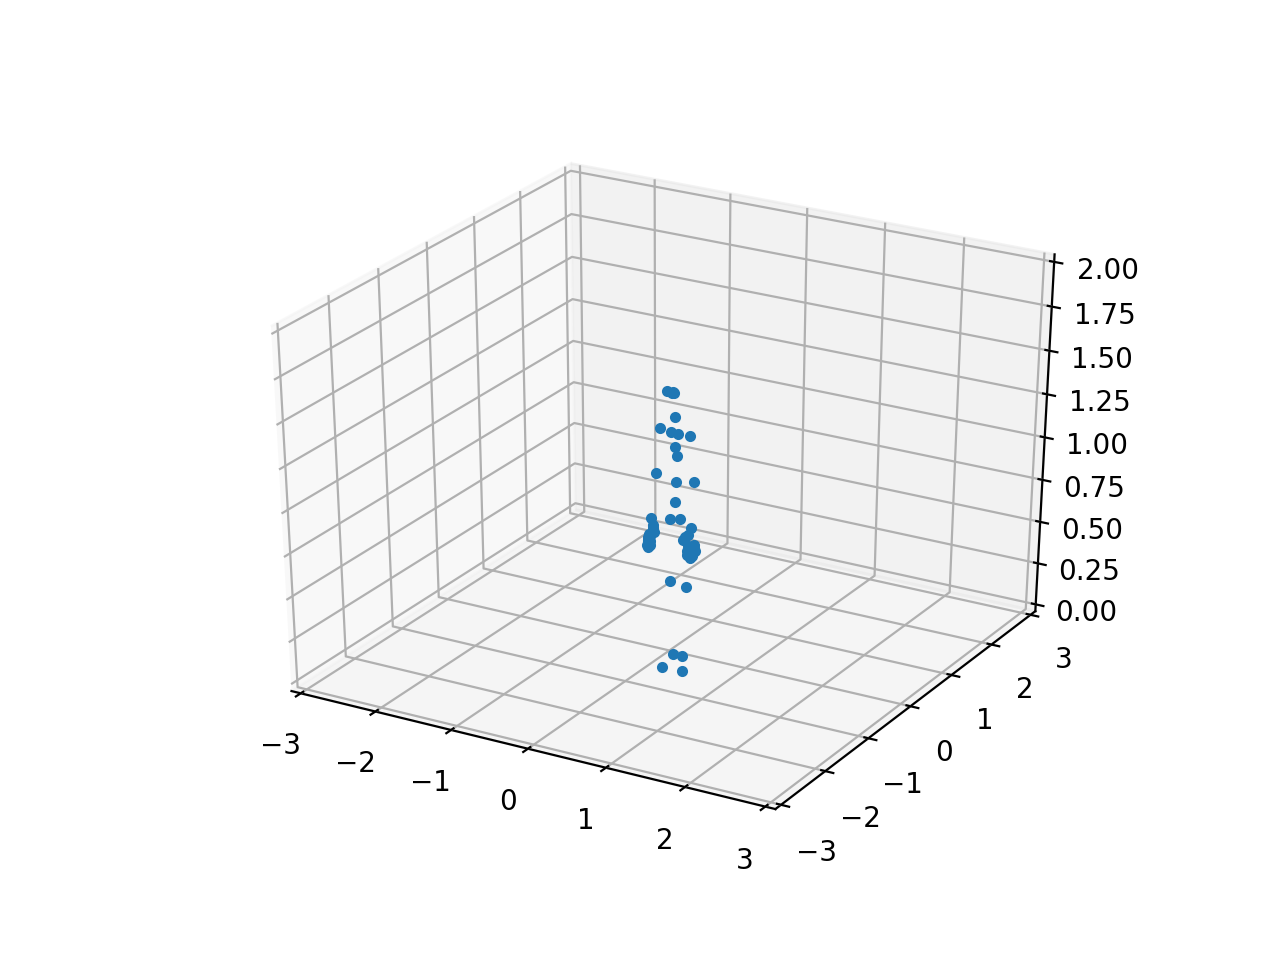

In [12]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot_xyz(fig, ax, body.Jtr.detach().cpu())